In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn.functional as F
import torchvision

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb
from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


In [19]:
## 하이퍼파라미터 세팅
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'inception_resnet_v2',
    'img_size': 260,
    'epochs': 200,
    'train_bs':128,
    'valid_bs':32,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 3,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 6,
    'model_path': './models'
}

In [3]:
project_name = 'carbon_reduction_inception_resnet_v2_update'
user = 'hojunking'
run_name = 'carbon_reduction_inception_resnet_v2_update'

In [48]:
main_path = '../Data/carbon_reduction/'
label_list = ["10kwalking","public_vehicle",'stair','pet','outlet','else', 'can', 'box', 'milk', 'cup']

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}')
    img_paths = [] 
    img_labels = []

    # default ratio
    train_ratio = 1500
    test_ratio = 500

    dir_path = main_path + label ## 레이블 폴더 경로
    count = 0
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
    
        for img in filenames: ## 각 파일 경로, 레이블 저장
            count +=1
            if count > train_ratio + test_ratio + 20000:
                break
            
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    random.shuffle(img_paths)
    print(f'img_paths len : {len(img_paths)}\n')

    if label == 'milk': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 1099
        test_ratio = 300
    elif label == 'public_vehicle': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 1425
        test_ratio = 300
    elif label == 'cup': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 1000
        test_ratio = 235
    elif label == 'stair': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 1660
        test_ratio = 500
    elif label == 'outlet': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 1627
        test_ratio = 400
    

    total_train_img_paths.extend(img_paths[:train_ratio])
    total_train_img_labels.extend(img_labels[:train_ratio])

    total_test_img_paths.extend(img_paths[-test_ratio:])
    total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))

label: 10kwalking
img_paths len : 2690

label: public_vehicle
img_paths len : 1725

label: stair
img_paths len : 2160

label: pet
img_paths len : 4335

label: outlet
img_paths len : 2027

label: else
img_paths len : 22000

label: can
img_paths len : 6516

label: box
img_paths len : 5198

label: milk
img_paths len : 1399

label: cup
img_paths len : 1235

Train_Images:  14311
Train_Images_labels: 14311
Test_Images:  4235
Test_Images_labels: 4235


In [49]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,삼성헬스 만보_034.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
1,만보인증_363.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
2,캐시워크 만보_383.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
3,나이키 만보_014.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
4,애플워치 만보_218.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
...,...,...,...
14306,else21482.jpg,../Data/carbon_reduction/cup/cups_from_else,cup
14307,양치컵_구글_300.jpg,../Data/carbon_reduction/cup/양치컵_구글,cup
14308,양치컵_008.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
14309,else25683.jpg,../Data/carbon_reduction/cup/cups_from_else,cup


In [50]:
# Label Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)

In [7]:
train.label.values

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
model =timm.create_model(CFG['model'], pretrained=True, num_classes=10)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [32]:
transform_train = A.Compose(
    [
        A.Resize(height = CFG['img_size']+100, width = CFG['img_size']+100),
        A.CenterCrop(always_apply=True, p=1.0, height=CFG['img_size'], width=CFG['img_size']),
        A.RandomBrightnessContrast(always_apply=False, p=0.8, brightness_limit=(0.00, 0.00), contrast_limit=(0.2, 0.2), brightness_by_max=False),
        A.SafeRotate(always_apply=False, p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.HorizontalFlip(always_apply=False, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

In [12]:
class ColonDataset(Dataset):
    def __init__(self, df, data_root, transform=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.data_root = data_root
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
                
        if self.output_label == True:
            return img, target
        else:
            return img

In [13]:
class ForcepImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        # n_features = self.model.classifier.in_features
        # self.model.classifier = nn.Linear(n_features, n_class)
    def freezing(self, freeze=False, trainable_layer = 2):
        
        if freeze:
            num_layers = len(list(model.parameters()))
            for i, param in enumerate(model.parameters()):
                if i < num_layers - trainable_layer*2:
                    param.requires_grad = False    
            
    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = ColonDataset(train_,
                            train_data_root,
                            transform=transform_train,
                            output_label=True)
    valid_ds = ColonDataset(valid_,
                            valid_data_root,
                            transform=transform_test,
                            output_label=True)
    

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [17]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    ## Sets the model to training mode
    model.train()
    
    t = time.time()
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
        
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    ## Sets the model to valid mode
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
model_dir = CFG['model_path'] + '/{}'.format(CFG['model'])
train_dir = train.dir.values

if __name__ == '__main__':
     # for training only, need nightly build pytorch
    wandb.init(project=project_name, entity=user)
    
#     wandb.login()
#     wandb.init(project="3class classification")
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    
    seed_everything(CFG['seed'])
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    best_fold = 0
    model_name = CFG['model']
    print(f'Model: {model_name}')
    for fold, (trn_idx, val_idx) in enumerate(folds):
    
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)
        
        ## Model definition
        device = torch.device(CFG['device'])
        model = ForcepImgClassifier(CFG['model'], train.label.nunique(), pretrained=True)
        
        ## Model Freezing
        model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")
        
        ## DataParallel
        model.to(device)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        
        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)
        
        ## criterion
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        best_f1 =0.0
        
        start = time.time()
        for epoch in range(CFG['epochs']):
            print(f'Fold: {fold}')
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))
            
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
                
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)
            
            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)
            
            
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                torch.save(model.state_dict(), (model_dir+'/{}_{}').format(CFG['model'],fold))
                
            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break
    
        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        
        print(f'fold: {fold}, Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        
        print(f'fold: {fold}, Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('---------------------------------------------------------')
        
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'best_fold : {best_fold}\n Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: inception_resnet_v2
Training start with fold: 0 epoch: 200 

Fold: 0
Epoch 0/199


  0%|                                                    | 0/90 [00:00<?, ?it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 0 loss: 1.8285:  44%|█████████▎           | 40/90 [00:40<00:37,  1.32it/s]

In [20]:
dist.destroy_process_group()

In [51]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,애플워치 만보_112.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
1,아이폰 걸음수_490.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
2,캐시워크 만보_236.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
3,삼성헬스 만보_014.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
4,애플워치 만보_242.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking
...,...,...,...
4230,양치컵_구글_019.jpg,../Data/carbon_reduction/cup/양치컵_구글,cup
4231,else38583.jpg,../Data/carbon_reduction/cup/cups_from_else,cup
4232,양치컵 사용_236.jpg,../Data/carbon_reduction/cup/양치컵 사용,cup
4233,양치컵_013.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup


In [45]:
test['label'] = le.fit_transform(test['label'].values)
test

In [25]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [52]:
model = ForcepImgClassifier(CFG['model'], test.label.nunique(), pretrained=True)
load_model = model_dir +'/' + CFG['model']+'_0'
test_dir = test.dir.values

tst_ds = ColonDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)

if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)

################## get inference #####################
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)

  0%|                                                    | 0/34 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
100%|███████████████████████████████████████████| 34/34 [00:14<00:00,  2.27it/s]


In [55]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,애플워치 만보_112.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking,10kwalking
1,아이폰 걸음수_490.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking,10kwalking
2,캐시워크 만보_236.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking,10kwalking
3,삼성헬스 만보_014.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking,10kwalking
4,애플워치 만보_242.jpg,../Data/carbon_reduction/10kwalking/10kwalking...,10kwalking,10kwalking
...,...,...,...,...
4230,양치컵_구글_019.jpg,../Data/carbon_reduction/cup/양치컵_구글,cup,cup
4231,else38583.jpg,../Data/carbon_reduction/cup/cups_from_else,cup,cup
4232,양치컵 사용_236.jpg,../Data/carbon_reduction/cup/양치컵 사용,cup,cup
4233,양치컵_013.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup,cup


accuracy: 0.9707
f1_score: 0.9690


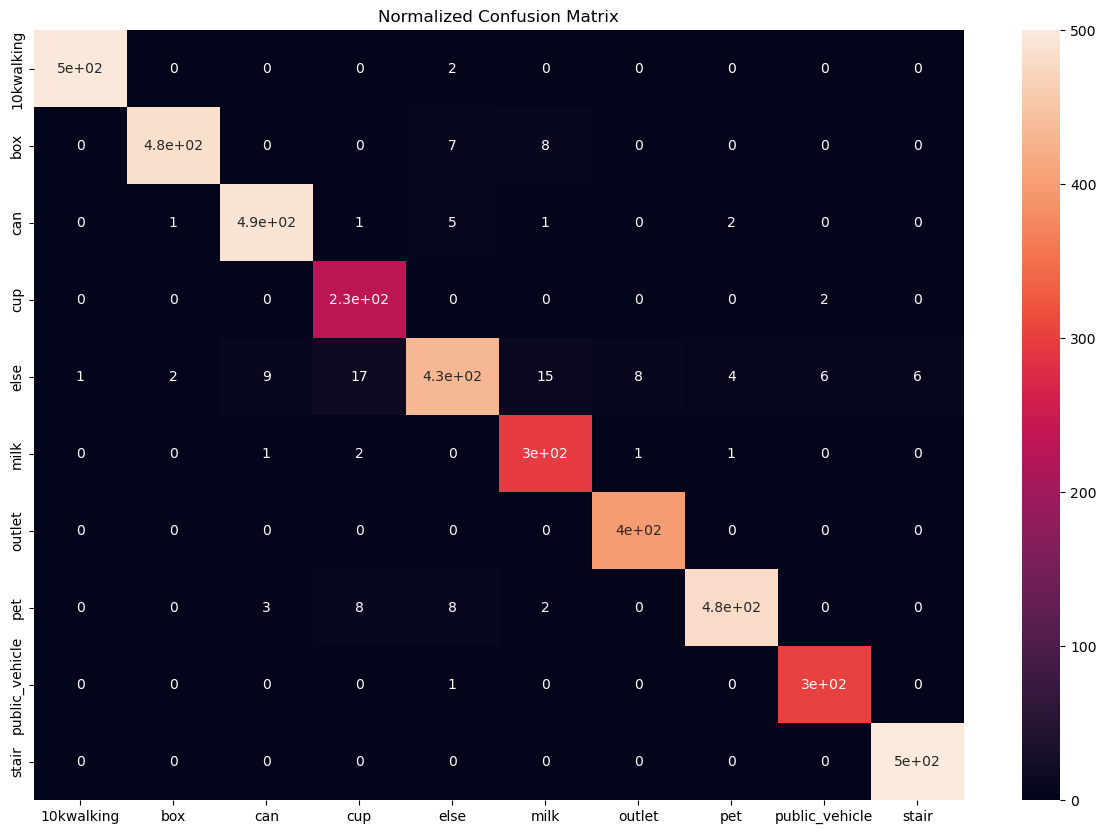

In [56]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

#test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)